### <font color='lightgrey'> Authentication with Google BigQuery service account key </font> 

<font color='lightgrey'> Before connecting to the Jupyter server, do the following in terminal window: <br>

```
export GOOGLE_APPLICATION_CREDENTIALS="/key/file/path/[FILE_NAME].json"
``` 
<br>

```
pip install --upgrade google-cloud-bigquery
``` </font> 

# Google BigQuery & BigQuery ML Playground - San Francisco Bikeshare
This playground project contains two parts. In the first part, I interact with the historic San Francisco bikeshare data hosted on Google's [BigQuery Public Datasets](https://cloud.google.com/bigquery/public-data/) using BigQuery SQL. In the second part, I create and execute a machine learning model right in BigQuery using pure SQL. More recent or real-time San Francisco bikeshare data (now rebranded as **Lyft Bay Wheels**) can be found [here](https://www.lyft.com/bikes/bay-wheels/system-data), which is not used in this project. 

# Some appetizers first
- The map below shows May 2016 bike pick-up events in SF 

In [9]:
%%HTML
# embed link

#### SQL query behind the visualziation above

In [56]:
query = """
        SELECT
            t.start_date AS start_date,
            t.trip_id AS trip_id,
            t.duration_sec AS duration,
            t.start_station_name AS origin_station,
            t.end_station_name AS destination_station,
            t.bike_number AS bike_number,
            t.subscriber_type AS subscriber_type,
            origin.latitude AS origin_lat,
            origin.longitude AS origin_lon,
            desti.latitude AS destination_lat,
            desti.longitude AS destination_lon
        FROM
            `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` t
            LEFT JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_stations` origin
            ON t.start_station_id = origin.station_id
            LEFT JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_stations` desti
            ON t.end_station_id = desti.station_id
        WHERE
            EXTRACT(MONTH FROM start_date) = 5 
            AND EXTRACT(YEAR FROM start_date) = 2016
        """

## Okay Let's start by importing some packages

In [11]:
from google.cloud import bigquery
%load_ext google.cloud.bigquery
client = bigquery.Client()

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from pandas.api.types import CategoricalDtype
import plotly as ply

plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#F5F5F5'
%matplotlib inline

### Logistics & cost control

For on-demand quries, the **first 1TB** each month is free of charge. After the 1TB treshold, it's **5 dollars/TB**. Depending on the dataset you work with, it may be be helpful to set up [custom cost controls](https://cloud.google.com/bigquery/docs/custom-quotas). Alternatively, you can use the [following](https://googleapis.github.io/google-cloud-python/latest/bigquery/generated/google.cloud.bigquery.job.QueryJobConfig.html) to prevent your quries from unintentionally scanning too much data (with maximum bytes allowed set to 1,000,000,000 as an example) :
```
safe_config = google.cloud.bigquery.QueryJobConfig(maximum_bytes_billed=1e9)
query_job = client.query(your_query, job_config=safe_config)
``` 

### The preliminaries

#### What tables does the San Francisco Bikeshare dataset have?

In [12]:
data_ref = client.dataset("san_francisco_bikeshare", project="bigquery-public-data")
data = client.get_dataset(data_ref)

tables = list(client.list_tables(data))
for table in tables:
    print(table.table_id)

bikeshare_regions
bikeshare_station_info
bikeshare_station_status
bikeshare_trips


#### Check schema for the bikeshare_trips table

In [13]:
client.get_table(data_ref.table("bikeshare_trips")).schema

[SchemaField('trip_id', 'INTEGER', 'REQUIRED', 'Numeric ID of bike trip', ()),
 SchemaField('duration_sec', 'INTEGER', 'NULLABLE', 'Time of trip in seconds', ()),
 SchemaField('start_date', 'TIMESTAMP', 'NULLABLE', 'Start date of trip with date and time, in PST', ()),
 SchemaField('start_station_name', 'STRING', 'NULLABLE', 'Station name of start station', ()),
 SchemaField('start_station_id', 'INTEGER', 'NULLABLE', 'Numeric reference for start station', ()),
 SchemaField('end_date', 'TIMESTAMP', 'NULLABLE', 'End date of trip with date and time, in PST', ()),
 SchemaField('end_station_name', 'STRING', 'NULLABLE', 'Station name for end station', ()),
 SchemaField('end_station_id', 'INTEGER', 'NULLABLE', 'Numeric reference for end station', ()),
 SchemaField('bike_number', 'INTEGER', 'NULLABLE', 'ID of bike used', ()),
 SchemaField('zip_code', 'STRING', 'NULLABLE', 'Home zip code of subscriber (customers can choose to manually enter zip at kiosk however data is unreliable)', ()),
 Schema

#### Sneak peak of the bikeshare_trips table

In [10]:
table_ref = data_ref.table("bikeshare_trips")
table = client.get_table(table_ref)
client.list_rows(table, max_results=5).to_dataframe()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,...,c_subscription_type,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,member_birth_year,member_gender,bike_share_for_all_trip,start_station_geom,end_station_geom
0,14620140831185000,1353,2014-08-31 18:50:00+00:00,California Ave Caltrain Station,36,2014-08-31 19:13:00+00:00,San Antonio Caltrain Station,29,146,94040,...,None,None,None,None,None,None,None,None,None,None
1,24320140831104700,2105,2014-08-31 10:47:00+00:00,St James Park,13,2014-08-31 11:22:00+00:00,St James Park,13,243,95112,...,None,None,None,None,None,None,None,None,None,None
2,17920140830180000,383,2014-08-30 18:00:00+00:00,San Antonio Shopping Center,31,2014-08-30 18:07:00+00:00,Rengstorff Avenue / California Street,33,179,94040-1724,...,None,None,None,None,None,None,None,None,None,None
3,16120140829165400,273,2014-08-29 16:54:00+00:00,San Pedro Square,6,2014-08-29 16:58:00+00:00,Ryland Park,84,161,94550,...,None,None,None,None,None,None,None,None,None,None
4,71420140826183800,241,2014-08-26 18:38:00+00:00,Cowper at University,37,2014-08-26 18:42:00+00:00,Palo Alto Caltrain Station,34,714,94133,...,None,None,None,None,None,None,None,None,None,None


## Part 1- BigQuery SQL 

#### What's the time frame of the dataset?
Get a table showing the earliest/latest timestamps
<font color='red'>Note that data from 9/1/2016 to 6/27/2017 is not available from the dataset; Ford GoBike launched on 6/28/2017. <font color>

In [14]:
time_frame_query = """
        WITH time_frame AS
        (
            SELECT
                MIN(start_date) AS earliest_date,
                MAX(start_date) AS latest_date
            FROM
                `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
        )
        SELECT
            earliest_date,
            latest_date,
            TIMESTAMP_DIFF(latest_date, earliest_date, DAY) AS total_num_days
        FROM
            time_frame
        """
time_frame = client.query(time_frame_query).result().to_dataframe()
time_frame

,earliest_date,latest_date,total_num_days
0,2013-08-29 09:08:00+00:00,2018-04-30 23:58:45+00:00,1705


#### How many trips were there and by whom?
Get a table showing number of trips broken down by subscriber type.

In [15]:
trips_query = """
        SELECT 
            COUNT(Subscriber_trip) Subscriber_Trips, 
            COUNT(Customer_trip) Customer_Trips, 
            COUNT(*) Total_Trips
        FROM 
            (SELECT 
                CASE WHEN subscriber_type = 'Subscriber' THEN 1 END Subscriber_trip, 
                CASE WHEN subscriber_type = 'Customer' THEN 1 END Customer_trip 
            FROM 
                `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`)
        """

trips = client.query(trips_query).to_dataframe()
trips

,Subscriber_Trips,Customer_Trips,Total_Trips
0,1635448,311971,1947419


#### The same query as above, but using magic commands (just for fun)

In [16]:
%%bigquery
SELECT 
    COUNT(Subscriber_trip) Subscriber_Trips, 
    COUNT(Customer_trip) Customer_Trips, 
    COUNT(*) Total_Trips
FROM 
    (SELECT 
        CASE WHEN subscriber_type = 'Subscriber' THEN 1 END Subscriber_trip, 
        CASE WHEN subscriber_type = 'Customer' THEN 1 END Customer_trip 
FROM 
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`)

,Subscriber_Trips,Customer_Trips,Total_Trips
0,1635448,311971,1947419


#### Let's break down trips by month and subscriber type
Get a table showing monthly trips by subscriber type
- Data from 4/1/2014 to 3/31/2016 is queried to avoid the missing period from 9/1/2016 to 6/27/2017 but still keep a full year

In [17]:
trips_by_month_query = """
                 SELECT
                     FORMAT_DATE('%B', DATE(start_date)) AS month,
                     COUNT(Subscriber_trip) AS subscriber_trips, 
                     COUNT(Customer_trip) AS customer_trips, 
                     COUNT(*) AS total_trips
                 FROM
                     (SELECT
                        start_date,
                        CASE WHEN subscriber_type = 'Subscriber' THEN 1 END Subscriber_trip, 
                        CASE WHEN subscriber_type = 'Customer' THEN 1 END Customer_trip 
                      FROM 
                        `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
                      WHERE
                        start_date >= '2014-04-01' AND start_date < '2016-04-01')
                 GROUP BY
                     1
                 ORDER BY
                     4 DESC
                 """

trips_by_month = client.query(trips_by_month_query).to_dataframe()
trips_by_month

,month,subscriber_trips,customer_trips,total_trips
0,October,57361,7912,65273
1,July,53779,9976,63755
2,August,52814,10305,63119
3,September,54244,7834,62078
4,June,53018,8871,61889
5,May,48922,9120,58042
6,April,50176,7408,57584
7,March,51035,6149,57184
8,February,45558,5403,50961
9,November,43990,4882,48872


Plot it

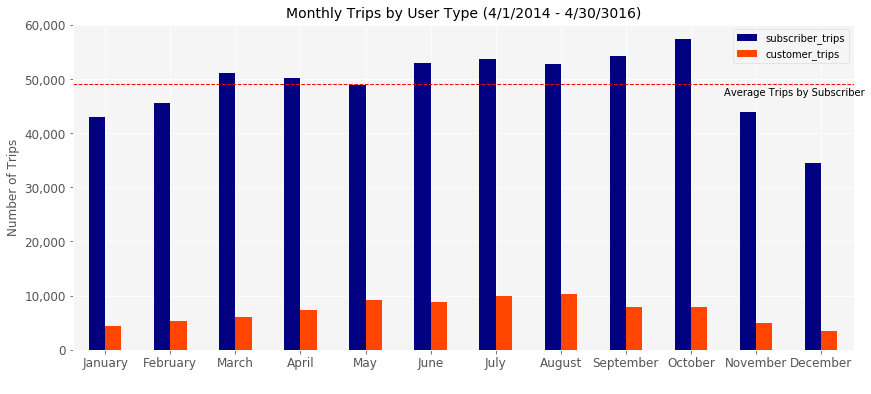

In [23]:
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

trips_by_month['month'] = pd.Categorical(trips_by_month['month'], categories=months, ordered=True)
trips_by_month.sort_values('month', inplace=True)

ax = trips_by_month.set_index('month')[['subscriber_trips', 'customer_trips']].plot(
    kind='bar', 
    rot=0, 
    figsize=(14,6), 
    color=['navy', 'orangered']
)

ax.set_title('Monthly Trips by User Type (4/1/2014 - 4/30/3016)', fontsize=14)
ax.set_ylabel('Number of Trips')
ax.set_xlabel(' ')

fmt = '{x:,.0f}'
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)

ax.axhline(trips_by_month['subscriber_trips'].mean(), color='red', linestyle='dashed',linewidth=1)
ax.text(9.5, 47000,'Average Trips by Subscriber', fontsize=10)

pass

#### How about after Ford GoBike's Launch?
Get a table showing monthly trips by subscriber type after Ford GoBike's launch on 6/28/2017.
- Data on or after 7/01/2017 is queried 

In [24]:
trips_by_month_query = """
                 SELECT
                     FORMAT_DATE('%B', DATE(start_date)) AS month,
                     COUNT(Subscriber_trip) AS subscriber_trips, 
                     COUNT(Customer_trip) AS customer_trips, 
                     COUNT(*) AS total_trips
                 FROM
                     (SELECT
                        start_date,
                        CASE WHEN subscriber_type = 'Subscriber' THEN 1 END Subscriber_trip, 
                        CASE WHEN subscriber_type = 'Customer' THEN 1 END Customer_trip 
                      FROM 
                        `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
                      WHERE
                        start_date >= '2017-07-01')
                 GROUP BY
                     1
                 ORDER BY
                     4 DESC
                 """

trips_by_month = client.query(trips_by_month_query).to_dataframe()
trips_by_month

,month,subscriber_trips,customer_trips,total_trips
0,April,109989,21180,131169
1,March,95075,16307,111382
2,October,87526,21411,108937
3,February,91857,14861,106718
4,September,74374,24184,98558
5,November,79636,15976,95612
6,January,82458,12344,94802
7,December,73579,12960,86539
8,August,60781,22511,83292
9,July,31095,12978,44073


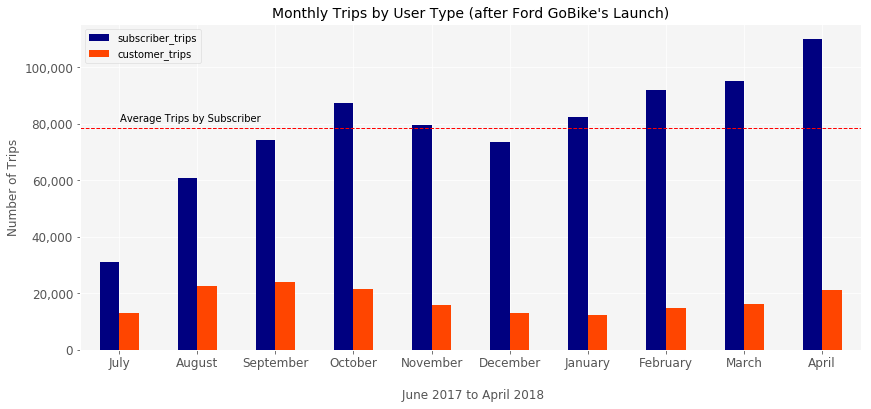

In [25]:
months = ["July", "August", "September", "October", "November", "December",
          "January", "February", "March", "April"]

trips_by_month['month'] = pd.Categorical(trips_by_month['month'], categories=months, ordered=True)
trips_by_month.sort_values('month', inplace=True)

ax = trips_by_month.set_index('month')[['subscriber_trips', 'customer_trips']].plot(
    kind='bar', 
    rot=0, 
    figsize=(14,6), 
    color=['navy', 'orangered']
)

ax.set_title('Monthly Trips by User Type (after Ford GoBike\'s Launch)', fontsize=14)
ax.set_ylabel('Number of Trips')
ax.set_xlabel('\n June 2017 to April 2018')

fmt = '{x:,.0f}'
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)

ax.axhline(trips_by_month['subscriber_trips'].mean(), color='red', linestyle='dashed',linewidth=1)
ax.text(0.01, 81000,'Average Trips by Subscriber', fontsize=10)

pass

#### Let's break number of trips further down by day of week and time of day for subscribers & non-subscribers
Get tables showing trips by day of week and hour of day
- data from 4/1/2014 to 4/30/2018 is queried

In [26]:
trips_dow_subscriber = """
                       SELECT 
                           EXTRACT (DAYOFWEEK FROM start_date) AS day_of_week,
                           EXTRACT (HOUR FROM start_date) AS hour,
                           COUNT(*) AS num_trips
                        FROM
                            `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
                        WHERE
                            subscriber_type = 'Subscriber'
                            AND start_date >= '2014-01-01' 
                            AND start_date < '2018-05-01'
                        GROUP BY
                            1,2
                        """

trips_dow_customer = """
                       SELECT 
                           EXTRACT (DAYOFWEEK FROM start_date) AS day_of_week,
                           EXTRACT (HOUR FROM start_date) AS hour,
                           COUNT(*) AS num_trips
                        FROM
                            `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
                        WHERE
                            subscriber_type = 'Customer'
                            AND start_date >= '2014-01-01' 
                            AND start_date < '2018-05-01'
                        GROUP BY
                            1,2
                        """

trips_dow_sub = client.query(trips_dow_subscriber).to_dataframe()
trips_dow_cus = client.query(trips_dow_customer).to_dataframe()

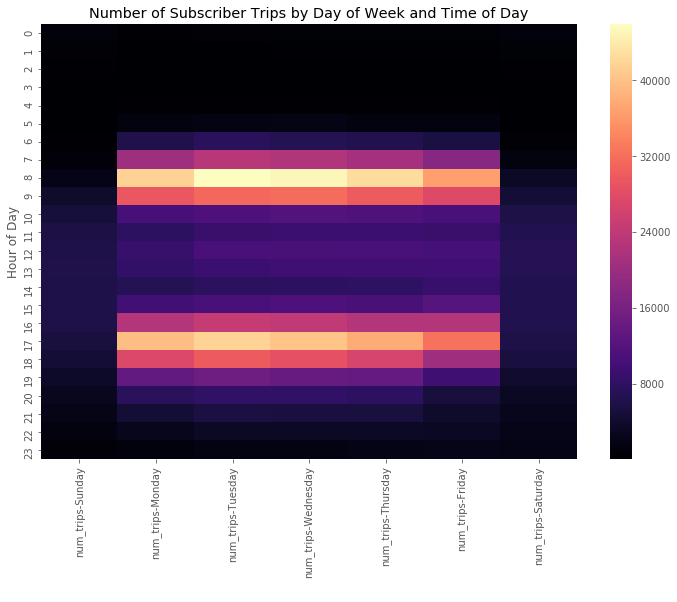

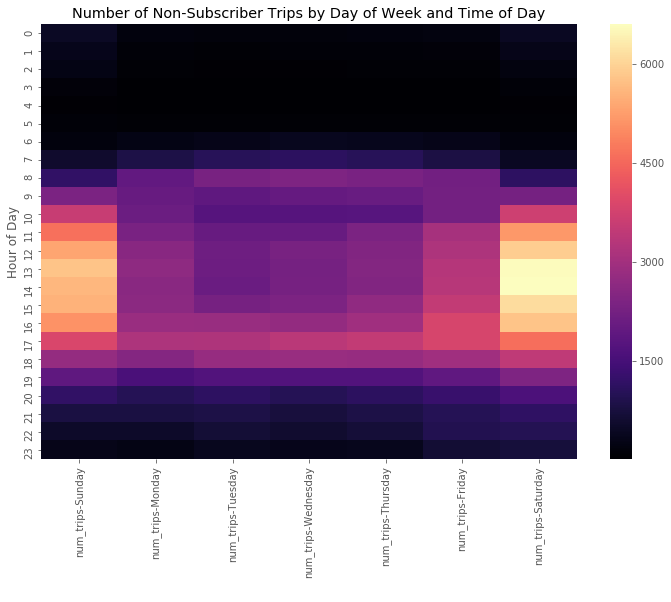

In [27]:
dow_dict = {
    1: "Sunday",
    2: "Monday",
    3: "Tuesday",
    4: "Wednesday",
    5: "Thursday",
    6: "Friday",
    7: "Saturday"
}

dow = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
trips_dow_sub['day_of_week'] = trips_dow_sub['day_of_week'].replace(dow_dict)
trips_dow_sub['day_of_week'] = trips_dow_sub['day_of_week'].astype(CategoricalDtype(dow, ordered=True))
trips_dow_cus['day_of_week'] = trips_dow_cus['day_of_week'].replace(dow_dict)
trips_dow_cus['day_of_week'] = trips_dow_cus['day_of_week'].astype(CategoricalDtype(dow, ordered=True))
trips_dow_sub = trips_dow_sub.groupby(['hour', 'day_of_week']).sum().unstack()
trips_dow_cus = trips_dow_cus.groupby(['hour', 'day_of_week']).sum().unstack()


data = [trips_dow_sub, trips_dow_cus]
title = ['Number of {} Trips by Day of Week and Time of Day'.format(i) for i in ('Subscriber', 'Non-Subscriber')]

plot_data = zip(data, title)

for item in plot_data:
    
    fig = plt.figure(figsize=(12,8))
    sns.heatmap(item[0], cmap='magma')

    plt.title(item[1])
    plt.xlabel(' ')
    plt.ylabel('Hour of Day')

pass

### Number of trips over time
Let's use a window function to obtain average daily trips, calculated over **a window including preceding 15 days and following 15 days** from 4/1/2014 to 4/30/2018

In [28]:
avg_num_trips_query_before = """
        WITH daily_trips AS
        (
            SELECT
                DATE(start_date) AS trip_date,
                COUNT(*) AS num_trips
            FROM
                `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
            WHERE
                start_date >= '2014-04-01' 
                AND start_date < '2018-04-30'
            GROUP BY
                trip_date
        )
        SELECT
            trip_date,
            AVG(num_trips) OVER(
                                ORDER BY trip_date
                                ROWS BETWEEN 15 PRECEDING AND 15 FOLLOWING
                                ) AS avg_num_trips
        FROM
            daily_trips
        """


avg_num_trips_query_after = """
        WITH daily_trips AS
        (
            SELECT
                DATE(start_date) AS trip_date,
                COUNT(*) AS num_trips
            FROM
                `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
            WHERE
                start_date >= '2017-06-28' 
            GROUP BY
                trip_date
        )
        SELECT
            trip_date,
            AVG(num_trips) OVER(
                                ORDER BY trip_date
                                ROWS BETWEEN 15 PRECEDING AND 15 FOLLOWING
                                ) AS avg_num_trips
        FROM
            daily_trips
        """

avg_num_trips_before = client.query(avg_num_trips_query_before).result().to_dataframe()
avg_num_trips_after = client.query(avg_num_trips_query_after).result().to_dataframe()

- Aside from the missing data, we can see the typical holiday dips and weekday/weekend variations

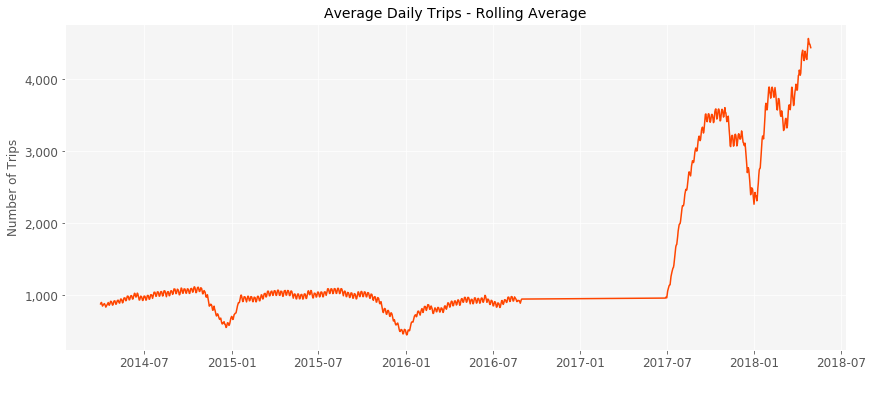

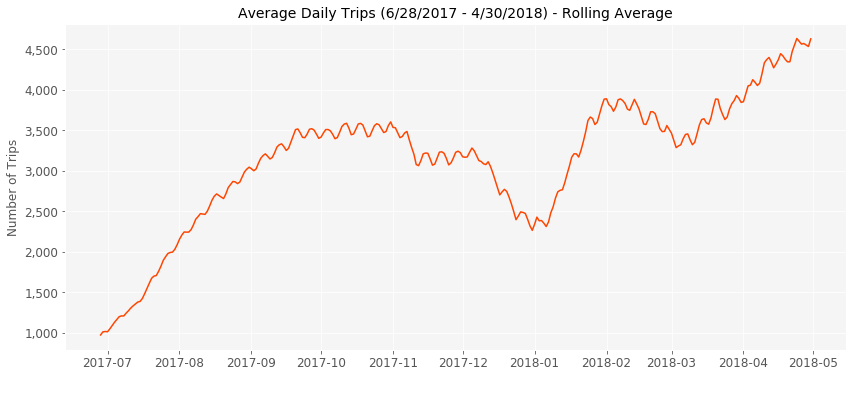

In [29]:
data = [avg_num_trips_before, avg_num_trips_after]
title = ['Average Daily Trips{}- Rolling Average'.format(i) for i in (' ', ' (6/28/2017 - 4/30/2018) ')]

plot_data = zip(data, title)

for item in plot_data:
    
    ax = item[0].set_index('trip_date').plot(
        kind='line', 
        rot=0, 
        figsize=(14, 6), 
        color=['orangered']
    )

    ax.set_title(item[1], fontsize=14)
    ax.set_ylabel('Number of Trips')
    ax.set_xlabel(' ')
    ax.get_legend().remove()

    fmt = '{x:,.0f}'
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)

pass

### Trip Duration - How long were the trips? 

#### Trips less than 30 mins
Prepare a table showing user type, number of trips less than 30 mins, and percentage share of those trips
- most subscriber trips were under 30 mins

In [30]:
trip_duration_30_query = """
                         SELECT
                             subscriber_type AS user_type,
                             COUNT(*) AS total_trips,
                             COUNT(*)/(
                                      SELECT
                                          COUNT(*)
                                      FROM
                                          `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
                                      WHERE
                                          subscriber_type = CASE WHEN t.subscriber_type = 'Customer'
                                                            THEN 'Customer'
                                                            ELSE 'Subscriber'
                                                            END
                                          AND start_date >= '2017-06-28'
                                      ) AS percentage_share
                          FROM
                              `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` t
                          WHERE
                              (duration_sec)/60 <= 30
                              AND start_date >= '2017-06-28'
                          GROUP BY
                              1
                          """

trip_duration_30 = client.query(trip_duration_30_query).result().to_dataframe()
trip_duration_30.head()

,user_type,total_trips,percentage_share
0,Subscriber,772086,0.979048
1,Customer,134853,0.769876


#### Trips less than 15 mins
Prepare a table showing user type, number of trips less than 15 mins, and percentage share of those trips

In [31]:
trip_duration_15_query = """
                         SELECT
                             subscriber_type AS user_type,
                             COUNT(*) AS total_trips,
                             COUNT(*)/(
                                      SELECT
                                          COUNT(*)
                                      FROM
                                          `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
                                      WHERE
                                          subscriber_type = CASE WHEN t.subscriber_type = 'Customer'
                                                            THEN 'Customer'
                                                            ELSE 'Subscriber'
                                                            END
                                          AND start_date >= '2017-06-28'
                                      ) AS percentage_share
                          FROM
                              `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` t
                          WHERE
                              (duration_sec)/60 <= 15
                              AND start_date >= '2017-06-28'
                          GROUP BY
                              1
                          """

trip_duration_15 = client.query(trip_duration_15_query).result().to_dataframe()
trip_duration_15.head()

,user_type,total_trips,percentage_share
0,Subscriber,650912,0.825393
1,Customer,72244,0.412441


#### How long is the longest trip?
- Great, the longest trip is almost 200 days long - most likely a data problem

In [32]:
longest_trip_query = """
                     SELECT
                         start_date,
                         end_date,
                         subscriber_type,
                         start_station_name,
                         end_station_name,
                         duration_sec/60/60/24 AS num_days
                     FROM
                         `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
                     ORDER BY
                         6 DESC
                     LIMIT 5
                     """

longest_trip = client.query(longest_trip_query).result().to_dataframe()
longest_trip

,start_date,end_date,subscriber_type,start_station_name,end_station_name,num_days
0,2014-12-06 21:59:00+00:00,2015-06-24 20:18:00+00:00,Customer,South Van Ness at Market,2nd at Folsom,199.888889
1,2015-06-28 21:50:00+00:00,2015-07-23 15:27:00+00:00,Customer,Market at Sansome,Yerba Buena Center of the Arts (3rd @ Howard),24.733796
2,2015-05-02 06:17:00+00:00,2015-05-23 16:53:00+00:00,Subscriber,San Antonio Shopping Center,Castro Street and El Camino Real,21.442014
3,2015-07-10 10:35:00+00:00,2015-07-23 13:27:00+00:00,Customer,University and Emerson,University and Emerson,13.119676
4,2013-11-30 13:29:00+00:00,2013-12-08 22:06:00+00:00,Customer,University and Emerson,University and Emerson,8.359213


#### Average trip length for subscribers and non-subscribers
- Since extreme outliers like the above exit in the dataset, let's take the average of trip length by subscriber type, **excluding the shortest and longest 1%**!

In [33]:
avg_trip_length_query = """
                      WITH percentile10 AS 
                      (
                          SELECT
                              DISTINCT subscriber_type,
                              PERCENTILE_CONT(duration_sec, 0.01) OVER(PARTITION BY subscriber_type) AS percentile
                          FROM
                              `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
                          WHERE
                              start_date > '2017-06-28'
                      ),
                      percentile90 AS
                      (
                          SELECT
                              DISTINCT subscriber_type,
                              PERCENTILE_CONT(duration_sec, 0.99) OVER(PARTITION BY subscriber_type) AS percentile
                          FROM
                              `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
                          WHERE
                              start_date > '2017-06-28'
                      )
                      SELECT
                          t.subscriber_type AS user_type,
                          AVG(duration_sec)/60 AS avg_trip_mins,
                          MIN(duration_sec)/60 AS min_trip_mins,
                          MAX(duration_sec)/60 AS max_trip_mins
                      FROM
                          `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` t
                          LEFT JOIN percentile10 p1 
                          ON p1.subscriber_type = t.subscriber_type
                          LEFT JOIN percentile90 p99
                          ON p99.subscriber_type = t.subscriber_type
                      WHERE
                          start_date > '2017-06-28'
                          AND t.duration_sec > p1.percentile
                          AND t.duration_sec < p99.percentile
                      GROUP BY
                          user_type
                      """
avg_trip_length = client.query(avg_trip_length_query).result().to_dataframe()
avg_trip_length

,user_type,avg_trip_mins,min_trip_mins,max_trip_mins
0,Subscriber,10.038876,1.916667,40.316667
1,Customer,32.364985,2.883333,461.750000


stats charts here using plotly

### Most popular commuter trips (after 6/27/2017)
Prepare a table showing popular commute trips with origin-destination pairs
- trips with at most 30-min duration
- trips with different origin/destination locations

In [34]:
trip_route_query = """
                   SELECT
                       start_station_name,
                       end_station_name,
                       COUNT(*) AS num_trips,
                       o.lat AS origin_lat,
                       o.lon AS origin_lon,
                       d.lat AS destination_lat,
                       d.lon AS destination_lon
                   FROM
                       `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` t
                       LEFT JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` o
                       ON t.start_station_id = o.station_id
                       LEFT JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` d
                       ON t.end_station_id = d.station_id
                   WHERE
                       duration_sec/60 <= 30
                       AND start_date >= '2017-06-28'
                       AND start_station_id <> end_station_id
                   GROUP BY
                       1, 2, 4, 5, 6, 7
                   ORDER BY
                       num_trips DESC
                   """
trip_route = client.query(trip_route_query).result().to_dataframe()
trip_route.head(10)

,start_station_name,end_station_name,num_trips,origin_lat,origin_lon,destination_lat,destination_lon
0,San Francisco Ferry Building (Harry Bridges Pl...,The Embarcadero at Sansome St,4679,37.795392,-122.394203,37.804770,-122.403234
1,The Embarcadero at Sansome St,Steuart St at Market St,3074,37.804770,-122.403234,37.794130,-122.394430
2,Berry St at 4th St,San Francisco Ferry Building (Harry Bridges Pl...,2998,37.775880,-122.393170,37.795392,-122.394203
3,The Embarcadero at Sansome St,San Francisco Ferry Building (Harry Bridges Pl...,2621,37.804770,-122.403234,37.795392,-122.394203
4,San Francisco Ferry Building (Harry Bridges Pl...,Berry St at 4th St,2484,37.795392,-122.394203,37.775880,-122.393170
5,19th Street BART Station,Grand Ave at Perkins St,2341,37.809013,-122.268247,37.808894,-122.256460
6,Steuart St at Market St,The Embarcadero at Sansome St,2149,37.794130,-122.394430,37.804770,-122.403234
7,Grand Ave at Perkins St,19th Street BART Station,2063,37.808894,-122.256460,37.809013,-122.268247
8,Market St at 10th St,San Francisco Caltrain Station 2 (Townsend St...,2015,37.776619,-122.417385,NaN,NaN
9,Bay Pl at Vernon St,19th Street BART Station,1960,37.812314,-122.260779,37.809013,-122.268247


In [60]:
%%HTML
# embed link

#### What are the new stations across years? 

In [37]:
sta_2013_query = """
                 SELECT
                   DISTINCT(start_station_name)
                 FROM
                   `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
                 WHERE
                   EXTRACT(YEAR FROM start_date) = 2013
                 """
sta_2015_query = """
                 SELECT
                   DISTINCT(start_station_name)
                 FROM
                   `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
                 WHERE
                   EXTRACT(YEAR FROM start_date) = 2015
                 """
sta_2018_query = """
                 SELECT
                   DISTINCT(start_station_name)
                 FROM
                   `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
                 WHERE
                   EXTRACT(YEAR FROM start_date) = 2018
                 """
sta_2013 = client.query(sta_2013_query).result().to_dataframe()
sta_2015 = client.query(sta_2015_query).result().to_dataframe()
sta_2018 = client.query(sta_2018_query).result().to_dataframe()

sta_15_13 = set(sta_2015['start_station_name']) - set(sta_2013['start_station_name'])
sta_18_15 = set(sta_2018['start_station_name']) - set(sta_2015['start_station_name'])

In [43]:
print("New stations in 2015 but not in 2013 are: {}".format(sta_15_13))
print("-"*30)
print("New stations in 2018 but not in 2015 are: {}".format(sta_18_15))

New stations in 2015 but not in 2013 are: {'Washington at Kearny', 'Sequoia Hospital', 'Mezes', 'Mezes Park', 'Ryland Park', 'San Antonio Shopping Center', 'Kaiser Hospital', 'Post at Kearny', 'Stanford in Redwood City', 'Broadway St at Battery St', 'Santa Clara County Civic Center', 'Castro Street and El Camino Real', 'Middlefield Light Rail Station', 'Charleston Park/ North Bayshore Area'}
------------------------------
New stations in 2018 but not in 2015 are: {'Foothill Blvd at Fruitvale Ave', 'Derby St at College Ave', 'Stanford Ave at Hollis St', 'Mosswood Park', 'The Embarcadero at Vallejo St', 'Locust St at Grant St', 'San Pablo Ave at MLK Jr Way', 'Paseo De San Antonio at 2nd St', 'MacArthur BART Station', 'Bushrod Park', 'Market St at Dolores St', 'Ashby BART Station', 'San Pablo Ave at 27th St', '17th St at Dolores St', 'College Ave at Taft Ave', 'Post St at Kearny St', '45th St at MLK Jr Way', '2nd Ave at E 18th St', 'Telegraph Ave at 23rd St', 'Townsend St at 7th St', 'San

#### What if we want to track the starting and ending stations for bikes on a particular day?
- Let's track each bike's starting and ending locations on March 07, 2016

In [36]:
query = """
        SELECT
            DISTINCT bike_number,
            FIRST_VALUE(start_station_name) 
                OVER(
                    PARTITION BY bike_number
                    ORDER BY start_date
                    ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                    ) AS first_station,
            LAST_VALUE(end_station_name)
                OVER(
                    PARTITION BY bike_number
                    ORDER BY start_date
                    ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                    ) AS last_station
            FROM
                `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
            WHERE
                DATE(start_date) = '2016-03-07'
        """

station_tracking_result = client.query(query).result().to_dataframe()
station_tracking_result.head()

,bike_number,first_station,last_station
0,12,Castro Street and El Camino Real,Mountain View Caltrain Station
1,15,Santa Clara at Almaden,Japantown
2,16,Broadway St at Battery St,Market at Sansome
3,25,Spear at Folsom,Temporary Transbay Terminal (Howard at Beale)
4,29,San Francisco City Hall,Powell Street BART


# Part 2 - BigQuery ML (BQML)
- Objective: to build a model to predict how many riders, on average, will start from each station during each hour, capturing patterns in seasonality, time of day, and day of week (since I'm relying on the bikeshare dataset itself only). Let's predict the number of rides based on the station where the trip starts and the hour when the trip started.

### Connect to a project
- Here is where you enter your project name on Google Cloud
- After connecting to a project, you then create a dataset 

In [297]:
PROJECT_ID = 'vital-charger-240201'
from google.cloud import bigquery

client = bigquery.Client(project=PROJECT_ID, location="US")
dataset = client.create_dataset('model_dataset', exists_ok=True)

from google.cloud.bigquery import magics

### Training data
Since we have consistent data from **8/29/2013 to 8/30/2016**, let's use data prior to **1/1/2016** to train our model. We can use data after 1/1/2016 as testing data.

Let's first take a look at the training data

In [46]:
%%bigquery
SELECT
    start_station_name,
    TIMESTAMP_TRUNC(start_date, HOUR) AS start_hour,
    COUNT(*) AS num_trips
FROM
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
WHERE
    start_date < '2016-01-01'
GROUP BY
    1, 2
ORDER BY
    num_trips DESC
LIMIT 5

,start_station_name,start_hour,num_trips
0,San Francisco Caltrain (Townsend at 4th),2015-01-28 08:00:00+00:00,52
1,San Francisco Caltrain 2 (330 Townsend),2015-10-15 08:00:00+00:00,50
2,San Francisco Caltrain 2 (330 Townsend),2015-10-08 08:00:00+00:00,48
3,San Francisco Caltrain 2 (330 Townsend),2015-09-02 08:00:00+00:00,46
4,San Francisco Caltrain (Townsend at 4th),2015-01-07 08:00:00+00:00,45


### Let's look at average daily rides per station by year to see if there is any anomalies

In [47]:
%%bigquery
WITH daily_rides AS (
    SELECT COUNT(DISTINCT trip_id) AS num_rides,
           start_station_name,
           EXTRACT(DAYOFYEAR from start_date) AS doy,
           EXTRACT(YEAR from start_date) AS year
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    GROUP BY start_station_name, doy, year
    ORDER BY year
), 
station_averages AS (
    SELECT avg(num_rides) AS avg_riders, start_station_name, year
    FROM daily_rides
    GROUP BY start_station_name, year)

SELECT avg(avg_riders) AS daily_rides_per_station, year
FROM station_averages
GROUP BY year
ORDER BY year

,daily_rides_per_station,year
0,12.866044,2013
1,12.759052,2014
2,13.144572,2015
3,12.129674,2016
4,12.010358,2017
5,13.233681,2018


### Create the model
- Here we label the dependent variable with "label"

In [48]:
%%bigquery
CREATE OR REPLACE MODEL `model_dataset.bqml_sfbikeshare`
OPTIONS(model_type='linear_reg', OPTIMIZE_STRATEGY='batch_gradient_descent') AS
    SELECT
        COUNT(DISTINCT trip_id) AS label,
        IFNULL(start_station_name,"") AS start_station_name,
        TIMESTAMP_TRUNC(start_date, HOUR) AS start_hour
    FROM
        `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    WHERE
        start_date < '2016-01-01'
    GROUP BY
        2, 3

""


### Obtain training statistics
Based on [BigQuery ML Documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train):
- `iteration` represents the number of the training run. The value for the first iteration is zero.
- `loss` represents the loss metric calculated after an interation on the training data. We will be looking at the loss, which is penalty for bad prediction. A perfect prediction will have a loss of zero.
- `eval_loss` is the same loss metric calculated on the testing data.

In [49]:
%%bigquery
SELECT
    *
FROM
    ML.TRAINING_INFO(MODEL `model_dataset.bqml_sfbikeshare`)
ORDER BY
    iteration

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,6.037262,5.707029,0.1,8185
1,0,1,5.529751,5.283917,0.2,10465
2,0,2,5.177954,4.949803,0.4,12006
3,0,3,4.875794,4.685564,0.1,10903
4,0,4,4.777863,4.607359,0.2,10312
5,0,5,4.671802,4.513074,0.4,10335
6,0,6,4.642703,4.499894,0.2,9959


### Evaluate the model
Let's evaluate our model using testing data from **1/1/2016 to 6/28/2016**

In [52]:
%%bigquery
SELECT
  *
FROM ML.EVALUATE(MODEL `model_dataset.bqml_sfbikeshare`, (
    SELECT
        start_station_name,
        TIMESTAMP_TRUNC(start_date, HOUR) AS start_hour,
        COUNT(DISTINCT trip_id) AS label
    FROM
        `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    WHERE
        start_date >= '2016-01-01'
        AND start_date < '2016-06-28'
    GROUP BY
        1, 2))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,1.353931,6.071242,0.194471,0.852822,0.267032,0.2682


### Predictions

#### Overall trips per station per hour

In [53]:
%%bigquery
SELECT
    AVG(ROUND(predicted_label)) AS predicted_avg_trips,
    AVG(label) AS actual_avg_trips
FROM
    ML.PREDICT(MODEL `model_dataset.bqml_sfbikeshare`, (
    SELECT 
        COUNT(bike_number) AS label,
        start_station_name,
        TIMESTAMP_TRUNC(start_date, HOUR) AS start_hour
    FROM
        `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    WHERE
        start_date >= '2016-01-01'
        AND start_date < '2016-06-28'
    GROUP BY
        start_station_name, start_hour
    ))

,predicted_avg_trips,actual_avg_trips
0,2.357306,2.443248


#### A particular station - South Van Ness at Market

In [57]:
%%bigquery
SELECT
    AVG(ROUND(predicted_label)) AS predicted_avg_trips,
    AVG(label) AS actual_avg_trips
FROM
    ML.PREDICT(MODEL `model_dataset.bqml_sfbikeshare`, (
    SELECT 
        COUNT(bike_number) AS label,
        start_station_name,
        TIMESTAMP_TRUNC(start_date, HOUR) AS start_hour
    FROM
        `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    WHERE
        start_date >= '2016-01-01'
        AND start_date < '2016-06-28'
        AND start_station_name = 'South Van Ness at Market'
    GROUP BY
        start_station_name, start_hour
    ))

,predicted_avg_trips,actual_avg_trips
0,2.105563,1.907989


#### A particular station & hour: South Van Ness at Market @ 8am

In [58]:
%%bigquery
SELECT
    AVG(ROUND(predicted_label)) AS predicted_avg_trips,
    AVG(label) AS actual_avg_trips
FROM
    ML.PREDICT(MODEL `model_dataset.bqml_sfbikeshare`, (
    SELECT 
        COUNT(bike_number) AS label,
        start_station_name,
        TIMESTAMP_TRUNC(start_date, HOUR) AS start_hour
    FROM
        `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    WHERE
        start_date >= '2016-01-01'
        AND start_date < '2016-06-28'
        AND start_station_name = 'South Van Ness at Market'
        AND EXTRACT(HOUR FROM start_date) = 8
    GROUP BY
        start_station_name, start_hour
    ))

,predicted_avg_trips,actual_avg_trips
0,3.82963,3.955556
